# <font color=red>Introduction to Model Deployment using TensorFlowModel</font>
<p style="margin-left:10%; margin-right:10%;"></font></p>

## Overview:

The `TensorFlowModel` class in Accelerated Data Science (ADS) is designed to allow you to rapidly get a model into production. The `.prepare()` method creates the model artifacts that are needed to deploy a functioning model without you having to configure it or write code. However, it does allow you to customize the `score.py` file as needed. Simulate a call to a deployed model with the `.verify()` method. This method calls the `load_model()` and `predict()` functions in the `score.py` file. Using `.verify()` allows you to debug your `score.py` file without having to deploy a model. The `.save()` method pushes your `TensorFlowModel` and the model artifacts to the model catalog. The `.deploy()` method deploys the model to a REST endpoint for you. Finally, the `.predict()` method allows you to call the endpoint to perform model inference.

These simples steps take your trained TensorFlow model and pushes it to production with just a few lines of code.

---

## Contents:

* <a href='#intro'>Introduction</a>
    * <a href="#intro_dataset">Dataset</a>
* <a href='#create'>Create a TensorFlow Model</a>
* <a href='#serialize'>TensorFlow Framework Serialization</a>
    * <a href='#serialize_tensorflowmodel'>Create a TensorFlowModel</a>
    * <a href='#serialize_prepare'>Prepare</a>
    * <a href='#serialize_verify'>Verify</a>
    * <a href='#serialize_save'>Save</a>
    * <a href='#serialize_deploy'>Deploy</a>
    * <a href='#serialize_predict'>Predict</a>
* <a href='#clean_up'>Clean Up</a>
* <a href='#ref'>References</a>    

---

Datasets are provided as a convenience. Datasets are considered third-party content and are not considered materials under your agreement with Oracle.
      
The [`Fashion_MNIST`](https://creativecommons.org/licenses/by/4.0/) dataset is used in this notebook.


In [1]:
import ads
import logging
import os
import pandas as pd
import tempfile
import tensorflow as tf
import tensorflow_datasets as tfds
import warnings

from ads.catalog.model import ModelCatalog
from ads.model.model_metadata import UseCaseType

from ads.dataset.factory import DatasetFactory
from ads.model.framework.tensorflow_model import TensorFlowModel
from shutil import rmtree
ads.set_auth(auth='resource_principal')

logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)
warnings.filterwarnings('ignore')

<a id='intro'></a>
# Introduction

<a id="intro_dataset"></a>
## Dataset

The [Fashion_MNIST](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/fashion_mnist) is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. Zalando intends Fashion-MNIST to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits.


Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255. The training and test data sets have 785 columns. The first column consists of the class labels (see above), and represents the article of clothing. The rest of the columns contain the pixel-values of the associated image.

**Note**: This notebook requires public internet access to download the sample dataset.


In [2]:
fmnist = tf.keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = fmnist.load_data()

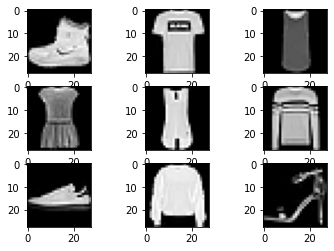

In [3]:
from matplotlib import pyplot as plt

for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(x_train[i], cmap='gray')
plt.show()

<a id='create'></a>
# Create a TensorFlow Model

The next cell creates a `TFModel` class that loads in the FMNIST data using a public internet connection. The data is then scaled to be between zero and one. To reduce the computational time needed to generate the model, only the first 10,000 training samples are used.

The TensorFlow model has an input layer of 784 nodes (28x28), a single dense, hidden layer of 128 nodes with a RELU activation function. The output layer consists of 10 dense nodes, one for each of the ten possible digits. A 20% drop-out is used to reduce overfitting.

check if 20% is optimum

In [4]:
class TFModel:

    fmnist = tf.keras.datasets.fashion_mnist
    (x_train, y_train), (x_test, y_test) = fmnist.load_data() # Load data
    x_train, x_test = x_train / 255.0, x_test / 255.0        # Scale between 0 and 1
    x_train, y_train = x_train[:10000], y_train[:10000]      # Reduce training data size

    def training(self):
        model = tf.keras.models.Sequential(
            [
                tf.keras.layers.Flatten(input_shape=(28, 28)),
                tf.keras.layers.Dense(128, activation="relu"),
                tf.keras.layers.Dropout(0.2),
                tf.keras.layers.Dense(10),
            ]
        )
        loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        model.compile(optimizer="adam", loss=loss_fn, metrics=["accuracy"])
        model.fit(self.x_train, self.y_train, epochs=1)

        return model

The next cell builds and trains the model:

In [5]:
model = TFModel().training()

313/313 [==============================] - 2s 3ms/step - loss: 0.7899 - accuracy: 0.7235


Once the model has been trained, you use the `.predict()` method to make predictions on a subset of the test dataset. Each prediction outputs ten values because there are ten nodes on the output layer. The node with the highest value is the digit that the model predicts.

In [6]:
model.predict(TFModel().x_test[0:1])

array([[-3.663918  , -4.0387115 , -2.6715229 , -4.1672783 , -3.2322648 ,
         2.6429946 , -2.49399   ,  3.0490901 ,  0.20881304,  4.374475  ]],
      dtype=float32)

<a id='serialize'></a>
# TensorFlow Framework Serialization

The TensorFlow framework makes it easy to deploy a TensorFlow model into production. The `TensorFlowModel()` constructor takes a TensorFlow model and converts it into a `TensorFlowModel` object. To deploy the model into production, you must prepare the model artifact, verify that the artifact works, save the model to the model catalog, and then deploy it.

ADS provides a number of methods that greatly simplify the model deployment process. It also provides the `.summary_status()` method that provides a dataframe that defines the steps, status, and detailed information about each step. 

<a id='serialize_tensorflowmodel'></a>
## Create a TensorFlowModel

In this notebook, a `keras.engine.sequential.Sequential` object is created. The `TensorFlowModel()` constructor takes the `keras.engine.sequential.Sequential` object along with the path that you want to use to store the model artifacts. A `TensorFlowModel` object is returned, and it's used to manage the deployment.

The next cell creates a model artifact directory. This directory is used to store the artifacts that are needed to deploy the model. It also creates the `TensorFlowModel` object.

In [7]:
artifact_dir = tempfile.mkdtemp()
print(f"Model artifact director: {artifact_dir}")
tf_model = TensorFlowModel(estimator=model, artifact_dir=artifact_dir)

Model artifact director: /tmp/tmpj17nlmlk


The `.summary_status()` method of the `TensorFlowModel` class is a handy method to keep track of the progress that you are making in deploying the model. It creates a dataframe that lists the deployment steps, their status, and details about them. The next cell returns the summary status dataframe. It shows that the initiate step has been completed.

In [8]:
tf_model.summary_status()

Actions Needed
Step      Status        Details                                                           
initiate  Done          Initiated the model                                               
prepare() Available     Generated runtime.yaml                                            
                        Generated score.py                                                
                        Serialized model                                                  
                        Populated metadata(Custom, Taxonomy and Provenance)               
verify()  Not Available Local tested .predict from score.py                               
save()    Not Available Conducted Introspect Test                                         
                        Uploaded artifact to model catalog                                
deploy()  Not Available Deployed the model                                                
predict() Not Available Called deployment predict endpoint

<a id='serialize_prepare'></a>
## Prepare

The prepare step is performed by the `.prepare()` method of the `TensorFlowModel` class. It creates a number of customized files that are used to run the model once it is deployed. These include:

* `input_schema.json`: A JSON file that defines the nature of the features of the `X_sample` data. It includes metadata such as the data type, name, constraints, summary statistics, feature type, and more.
* `model.h5`: This is the default filename of the serialized model. You can change it with the `model_file_name` attribute. By default, the model is stored in an h5 file. You can use the `as_onnx` parameter to save the model in the ONNX format.
* `output_schema.json`: A JSON file that defines the nature of the dependent variable in the `y_sample` data. It includes metadata such as the data type, name, constraints, summary statistics, feature type, and more.
* `runtime.yaml`: This file contains information that is needed to set up the runtime environment on the deployment server. It has information about which conda environment was used to train the model, and what environment should be used to deploy the model. The file also specifies what version of Python should be used.
* `score.py`: This script contains the `load_model()` and `predict()` functions. The `load_model()` function understands the format the model file was saved in, and loads it into memory. The `.predict()` method is used to make inferences in a deployed model. There are also hooks that allow you to perform operations before and after inference. You are able to modify this script to fit your specific needs.

To create the model artifacts, you use the `.prepare()` method. There are a number of parameters that allow you to store model provenance information. In the next cell, the `conda_env` variable defines the slug of the conda environment that was used to train the model, and the conda environment to use for deployment. Note that you can only pass in slugs to `inference_conda_env` or `training_conda_env` if it's a service environment. Otherwise, you must pass in the full path of the conda environment along with the python version through `inference_python_version` and `training_python_version`.


In [9]:
conda_env = 'tensorflow27_p37_cpu_v1'

tf_model.prepare(
    inference_conda_env=conda_env,
    training_conda_env=conda_env,
    use_case_type=UseCaseType.MULTINOMIAL_CLASSIFICATION,
    X_sample=TFModel().x_test,
    y_sample=TFModel().y_test,
)

algorithm: Sequential
artifact_dir:
  /tmp/tmpj17nlmlk:
  - - runtime.yaml
    - score.py
    - .model-ignore
    - output_schema.json
    - model.h5
framework: tensorflow
model_deployment_id: null
model_id: null

The next cell uses the `.summary_status()` method to show you that the prepare step finished, and what tasks were completed:

In [10]:
tf_model.summary_status()

Actions Needed
Step      Status        Details                                                           
initiate  Done          Initiated the model                                               
prepare() Done          Generated runtime.yaml                                            
                        Generated score.py                                                
                        Serialized model                                                  
                        Populated metadata(Custom, Taxonomy and Provenance)               
verify()  Available     Local tested .predict from score.py                               
save()    Available     Conducted Introspect Test                                         
                        Uploaded artifact to model catalog                                
deploy()  Not Available Deployed the model                                                
predict() Not Available Called deployment predict endpoint

The `.prepare()` method has created the following fully functional files. However, you can modify them to fit your specific needs.

In [11]:
os.listdir(artifact_dir)

['runtime.yaml', 'score.py', '.model-ignore', 'output_schema.json', 'model.h5']

Once the artifacts have been created, there are a number of attributes in the `TensorFlowModel` object that provide metadata about the model. The `.runtime` attribute details the model deployment settings and model provenance data.

In [12]:
tf_model.runtime_info

model_artifact_version: '3.0'
model_deployment:
  inference_conda_env:
    inference_env_path: oci://service-conda-packs@id19sfcrra6z/service_pack/cpu/TensorFlow_2.7_for_CPU_on_Python_3.7/1.0/tensorflow27_p37_cpu_v1
    inference_env_slug: tensorflow27_p37_cpu_v1
    inference_env_type: data_science
    inference_python_version: '3.7'
model_provenance:
  project_ocid: ''
  tenancy_ocid: ''
  training_code:
    artifact_directory: /tmp/tmpj17nlmlk
  training_compartment_ocid: ''
  training_conda_env:
    training_env_path: oci://service-conda-packs@id19sfcrra6z/service_pack/cpu/TensorFlow_2.7_for_CPU_on_Python_3.7/1.0/tensorflow27_p37_cpu_v1
    training_env_slug: tensorflow27_p37_cpu_v1
    training_env_type: data_science
    training_python_version: '3.7'
  training_region: ''
  training_resource_ocid: ''
  user_ocid: ''
  vm_image_internal_id: ''

The `.schema_input` attribute provides metadata on the features that were used to train the model. You can use this information to determine what data must be provided to make model inferences. Each feature in the model has a section that defines the dtype, feature type, name, and if it is required. The metadata also includes the summary statistics associated with the feature type.

In [13]:
tf_model.schema_input

schema: []
version: '1.1'

The `.metadata_custom` attribute provides custom metadata that contains information on the category of the metadata, description, key, and value:

In [14]:
tf_model.metadata_custom


data:
- category: Other
  description: ''
  key: ClientLibrary
  value: ADS
- category: Other
  description: The model file name.
  key: ModelFileName
  value: model.h5
- category: Training Profile
  description: The model serialization format.
  key: ModelSerializationFormat
  value: h5
- category: Training Environment
  description: The slug name of the training conda environment.
  key: SlugName
  value: tensorflow27_p37_cpu_v1
- category: Training Environment
  description: The list of files located in artifacts folder.
  key: ModelArtifacts
  value: runtime.yaml, score.py, .model-ignore, model.h5
- category: Training Environment
  description: The URI of the training conda environment.
  key: CondaEnvironmentPath
  value: oci://service-conda-packs@id19sfcrra6z/service_pack/cpu/TensorFlow_2.7_for_CPU_on_Python_3.7/1.0/tensorflow27_p37_cpu_v1
- category: Training Environment
  description: The conda environment type, can be published or datascience.
  key: EnvironmentType
  value: d

The `.metadata_provenance` contains information about the code and training data that was used to create the model. This information is most useful when a Git repository is being used to manage the code for training the model. This is considered a best practice because it allows you to do things like reproduce a model, perform forensic on the model, and so on.

In [15]:
tf_model.metadata_provenance

artifact_dir: null
git_branch: null
git_commit: null
repository_url: null
training_id: null
training_script_path: null

The `.metadata_taxonomy` is a key-value store that has information about the classification or taxonomy of the model. This can include information such as the model framework, use case type, hyperparameters, and more.

In [16]:
tf_model.metadata_taxonomy

data:
- key: Hyperparameters
  value: null
- key: UseCaseType
  value: multinomial_classification
- key: FrameworkVersion
  value: 2.7.0
- key: ArtifactTestResults
  value: null
- key: Framework
  value: tensorflow
- key: Algorithm
  value: Sequential

<a id='serialize_verify'></a>
## Verify

If you modify the `score.py` file that is part of the model artifacts, then you should verify it. The verify step allows you to test those changes without having to deploy the model. This allows you to debug your code without having to save the model to the model catalog, and then deploy it. The `.verify()` method takes a set of test parameters and performs the prediction by calling the `predict` function in `score.py`. It also runs the `load_model` function.

The next cell simulates a call to a deployed model without having to actually deploy the model. It passes in test values and returns the predictions.

In [17]:
tf_model.verify(TFModel().x_test[0:1])

Start loading model.h5 from model directory /tmp/tmpj17nlmlk ...
Model is successfully loaded.


{'prediction': [[-3.6639180183410645,
   -4.0387115478515625,
   -2.671522855758667,
   -4.167278289794922,
   -3.232264757156372,
   2.6429946422576904,
   -2.493989944458008,
   3.0490901470184326,
   0.20881304144859314,
   4.374475002288818]]}

Update the `.summary_status()` method to show that the verify step has been completed:

In [18]:
tf_model.summary_status()

Actions Needed
Step      Status        Details                                                           
initiate  Done          Initiated the model                                               
prepare() Done          Generated runtime.yaml                                            
                        Generated score.py                                                
                        Serialized model                                                  
                        Populated metadata(Custom, Taxonomy and Provenance)               
verify()  Done          Local tested .predict from score.py                               
save()    Available     Conducted Introspect Test                                         
                        Uploaded artifact to model catalog                                
deploy()  Not Available Deployed the model                                                
predict() Not Available Called deployment predict endpoint

<a id='serialize_save'></a>
## Save

Once you are satisfied with the performance of the model and have verified that the `score.py` file is working, you save the model to the model catalog. You do this with the `.save()` method on a `TensorFlowModel` object. This bundles up the model artifact that you have created, and deploys it to the model catalog. It returns the model OCID.

In [19]:
model_id = tf_model.save(display_name='Demo FMNIST TensorFlowModel model')

Start loading model.h5 from model directory /tmp/tmpj17nlmlk ...
Model is successfully loaded.
['runtime.yaml', 'score.py', '.model-ignore', 'output_schema.json', 'model.h5']


loop1:   0%|          | 0/4 [00:00<?, ?it/s]

In [20]:
tf_model.summary_status()

Actions Needed
Step      Status        Details                                                           
initiate  Done          Initiated the model                                               
prepare() Done          Generated runtime.yaml                                            
                        Generated score.py                                                
                        Serialized model                                                  
                        Populated metadata(Custom, Taxonomy and Provenance)               
verify()  Done          Local tested .predict from score.py                               
save()    Done          Conducted Introspect Test                                         
                        Uploaded artifact to model catalog                                
deploy()  Available     Deployed the model                                                
predict() Not Available Called deployment predict endpoint

<a id='serialize_deploy'></a>
## Deploy

When the model is in the model catalog, you can use the `.deploy()` method of a `TensorFlowModel` object to deploy the model. This method allows you to specify the attributes of the deployment such as the display name, description, instance type and count, the maximum bandwidth, and logging groups. The next cell deploys the model with the default settings, except for the custom display name. The `.deploy()` method returns a `ModelDeployment` object.

In [21]:
deploy = tf_model.deploy(display_name='Demo FMNIST TensorFlowModel deployment')

loop1:   0%|          | 0/6 [00:00<?, ?it/s]

After deployment, the `.summary_status()` method shows that the model is `ACTIVE` and the `predict()` method is available.

In [22]:
tf_model.summary_status()

Actions Needed
Step      Status    Details                                                           
initiate  Done      Initiated the model                                               
prepare() Done      Generated runtime.yaml                                            
                    Generated score.py                                                
                    Serialized model                                                  
                    Populated metadata(Custom, Taxonomy and Provenance)               
verify()  Done      Local tested .predict from score.py                               
save()    Done      Conducted Introspect Test                                         
                    Uploaded artifact to model catalog                                
deploy()  ACTIVE    Deployed the model                                                
predict() Available Called deployment predict endpoint

<a id='serialize_predict'></a>
## Predict

In the <a href='#create'>Create a TensorFlow Model</a> section, you used the `model.predict()` method where `model` is an `ADSModel` object. This did the inference using the local model. Now that the `TensorFlowModel` model has been deployed, you can do the same thing using similar syntax with the `.predict()` method on a `TensorFlowModel`.

After the deployment is active, you can call `predict()` on the `TensorFlowModel` object to send request to the deployed endpoint. 

In [23]:
tf_model.predict(TFModel().x_test[0:1])['prediction']

[[-3.6639180183410645,
  -4.0387115478515625,
  -2.671522855758667,
  -4.167278289794922,
  -3.232264757156372,
  2.6429946422576904,
  -2.493989944458008,
  3.0490901470184326,
  0.20881304144859314,
  4.374475002288818]]

<a id='clean_up'></a>
# Clean Up

This notebook created a model deployment and a model. This section deletes those resources. 

The model deployment must be deleted before the model can be deleted. You use the `.delete_deployment()` method on the `TensorFlowModel` object to do this.

In [24]:
delete = tf_model.delete_deployment(wait_for_completion=True)

loop1:   0%|          | 0/2 [00:00<?, ?it/s]

After the model deployment has been deleted, the `.summary_status()` method shows that the model has been deleted and that the `predict()` method is not available:

In [25]:
tf_model.summary_status()

Actions Needed
Step      Status        Details                                                           
initiate  Done          Initiated the model                                               
prepare() Done          Generated runtime.yaml                                            
                        Generated score.py                                                
                        Serialized model                                                  
                        Populated metadata(Custom, Taxonomy and Provenance)               
verify()  Done          Local tested .predict from score.py                               
save()    Done          Conducted Introspect Test                                         
                        Uploaded artifact to model catalog                                
deploy()  DELETED       Deployed the model                                                
predict() Not Available Called deployment predict endpoint

Use the `.delete_model()` method in a `ModelCatalog` object to delete the model:

In [26]:
ModelCatalog(compartment_id=os.environ['NB_SESSION_COMPARTMENT_OCID']).delete_model(model_id)

True

The next cell removes the model artifacts that were stored on your local drive:

In [27]:
rmtree(artifact_dir)

<a id='ref'></a>
# References
- [ADS Library Documentation](https://docs.cloud.oracle.com/en-us/iaas/tools/ads-sdk/latest/index.html)
- [Data Science YouTube Videos](https://www.youtube.com/playlist?list=PLKCk3OyNwIzv6CWMhvqSB_8MLJIZdO80L)
- [OCI Data Science Documentation](https://docs.cloud.oracle.com/en-us/iaas/data-science/using/data-science.htm)
- [Oracle Data & AI Blog](https://blogs.oracle.com/datascience/)
- [Understanding Conda Environments](https://docs.cloud.oracle.com/en-us/iaas/data-science/using/use-notebook-sessions.htm#conda_understand_environments)
- [Use Resource Manager to Configure Your Tenancy for Data Science](https://docs.cloud.oracle.com/en-us/iaas/data-science/using/orm-configure-tenancy.htm)
- [`runtime.yaml`](https://docs.content.oci.oracleiaas.com/en-us/iaas/data-science/using/model_runtime_yaml.htm#model_runtime_yaml)
- [`score.py`](https://docs.content.oci.oracleiaas.com/en-us/iaas/data-science/using/model_score_py.htm#model_score_py)
- [Model artifact](https://docs.content.oci.oracleiaas.com/en-us/iaas/data-science/using/models_saving_catalog.htm#create-models)
- [ONNX API Summary](http://onnx.ai/sklearn-onnx/api_summary.html)